In [76]:
import cdt.causality.graph.PC as PC
from cdt.independence.graph.Lasso import Glasso
import sklearn
from fancyimpute import IterativeImputer
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt

In [26]:
data = pd.read_csv("hw3_data/data.txt", sep=' ')

# # Trying 5 different values of alpha for the PC algorithm 
Seems like the smaller alpha values generate sparser DAGs.

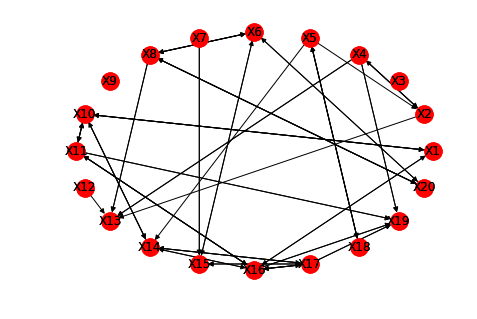

In [94]:
pc1 = PC(CItest='gaussian', method_indep='corr', alpha=0.001, verbose=None)
dag1 = pc1.create_graph_from_data(data)
nx.draw_circular(dag1, with_labels=True)

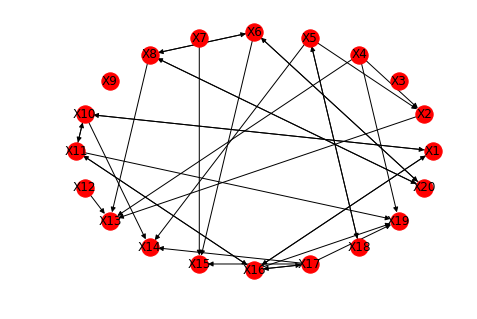

In [89]:
pc2 = PC(CItest='gaussian', method_indep='corr', alpha=0.01, verbose=None)
dag2 = pc2.create_graph_from_data(data)
nx.draw_circular(dag2, with_labels=True)

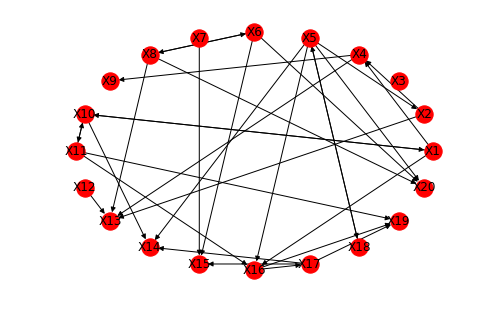

In [90]:
pc3 = PC(CItest='gaussian', method_indep='corr', alpha=0.1, verbose=None)
dag3 = pc3.create_graph_from_data(data)
nx.draw_circular(dag3, with_labels=True)

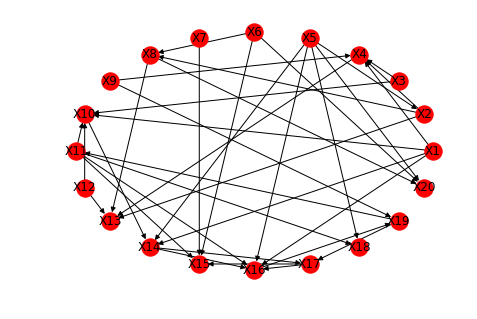

In [92]:
pc4 = PC(CItest='gaussian', method_indep='corr', alpha=0.5, verbose=None)
dag4 = pc4.create_graph_from_data(data)
nx.draw_circular(dag4, with_labels=True)

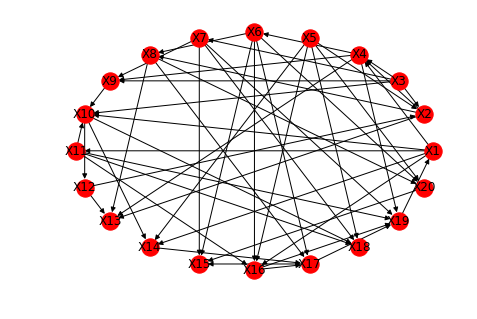

In [93]:
pc5 = PC(CItest='gaussian', method_indep='corr', alpha=0.9, verbose=None)
dag5 = pc5.create_graph_from_data(data)
nx.draw_circular(dag5, with_labels=True)

# # Trying 3 different values of alpha for Glasso algorithm.
Seems like larger alpha values generate sparser graphs, with small alpha values potentially causing the algorithm to not converge.

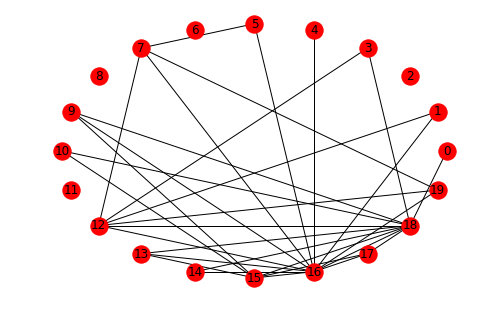

In [87]:
cov, prec = sklearn.covariance.graphical_lasso(emp_cov = np.cov(data.values.T), alpha = 0.9)

# Uses nonzero values of precision matrix as adjacency matrix
adj = np.where(prec != 0, 1, 0)
G = nx.from_numpy_matrix(adj) 
nx.draw_circular(G, with_labels=True)

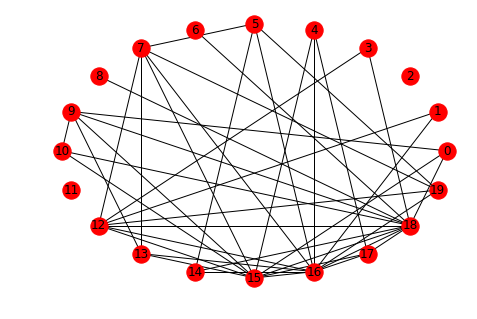

In [95]:
cov, prec = sklearn.covariance.graphical_lasso(emp_cov = np.cov(data.values.T), alpha = 0.5)
adj = np.where(prec != 0, 1, 0)
G = nx.from_numpy_matrix(adj) 
nx.draw_circular(G, with_labels=True)

graphical_lasso: did not converge after 100 iteration: dual gap: -2.564e-03


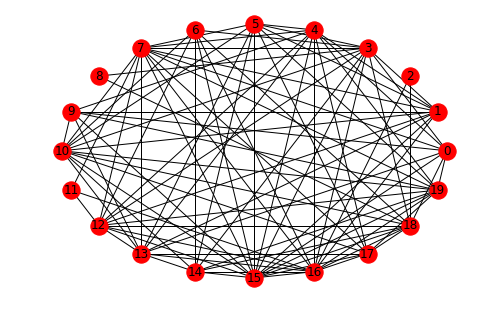

In [96]:
cov, prec = sklearn.covariance.graphical_lasso(emp_cov = np.cov(data.values.T), alpha = 0.1)
adj = np.where(prec != 0, 1, 0)
G = nx.from_numpy_matrix(adj) 
nx.draw_circular(G, with_labels=True)

# # Imputing data from incomplete source

In [64]:
n_imputations = 10
data_incomplete = pd.read_csv('hw3_data/data_missing.txt', sep=' ')
data_complete = []

# Imputes 10 datasets
for i in range(n_imputations):
    imputer = IterativeImputer(n_iter=5, sample_posterior=True, random_state=i)
    data_complete.append(imputer.fit_transform(data_incomplete))

# # NOTE: would use a metric such as BIC to determine optimal tuning for alpha
But did not have time to do this implementation.
Instead, I just manually chose values for the tuning parameter.

# # Learning DAGs and UGs using PC and Glasso

In [156]:
dag_adjs = []
ug_adjs = []

alpha_dag = 0.1
alpha_ug = 0.8

pc = PC(CItest='gaussian', method_indep='corr', alpha=alpha_dag, verbose=None)

for i in range(n_imputations):
    # For each imputed set, learns a DAG using PC and a UG using Glasso
    imp_data = data_complete[i]
    
    dag = pc.create_graph_from_data(pd.DataFrame(imp_data))
    dag_adjs.append(nx.to_numpy_matrix(dag))
    
    cov, prec = sklearn.covariance.graphical_lasso(emp_cov = np.cov(imp_data.T), alpha = alpha_ug)
    ug_adjs.append(np.where(prec != 0, 1, 0))

In [157]:
# Computes an "average" DAG and UG by summing all adjacency matrices
# Final adjacency matrix has a 1 if the sum is >=5, 0 otherwise

dag_sum = dag_adjs[0]
ug_sum = ug_adjs[0]

for i in range(9):
    dag_sum += dag_adjs[i+1]
    ug_sum += ug_adjs[i+1]
    
avg_dag = np.where(dag_sum >= 5, 1, 0)
avg_ug = np.where(ug_sum >= 5, 1, 0)

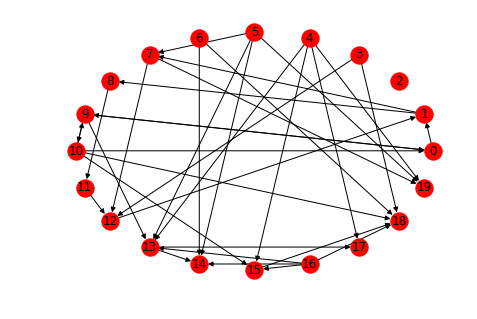

In [158]:
nx.draw_circular(nx.from_numpy_matrix(avg_dag, create_using = nx.DiGraph()), with_labels=True)

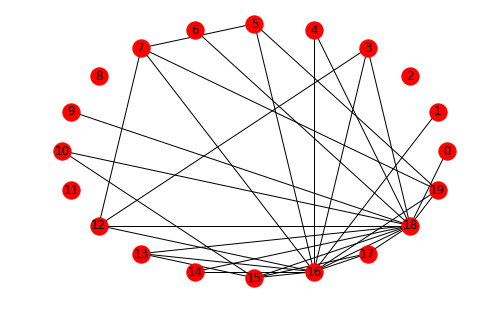

In [159]:
nx.draw_circular(nx.from_numpy_matrix(avg_ug), with_labels=True)